In [1]:
# from __future__ import unicode_literals
%matplotlib inline
import torch
import glob
import unicodedata
import string
import torch.nn as nn
from torch.autograd import Variable
import random
import time
import math
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

In [2]:
# 参考资料
# [Practical PyTorch: Classifying Names with a Character-Level RNN](https://github.com/spro/practical-pytorch/blob/master/char-rnn-classification/char-rnn-classification.ipynb)

In [3]:
all_filenames = glob.glob('../data/rnn/data/names/*.txt')
print(all_filenames)

['../data/rnn/data/names/Arabic.txt', '../data/rnn/data/names/Chinese.txt', '../data/rnn/data/names/Czech.txt', '../data/rnn/data/names/Dutch.txt', '../data/rnn/data/names/English.txt', '../data/rnn/data/names/French.txt', '../data/rnn/data/names/German.txt', '../data/rnn/data/names/Greek.txt', '../data/rnn/data/names/Irish.txt', '../data/rnn/data/names/Italian.txt', '../data/rnn/data/names/Japanese.txt', '../data/rnn/data/names/Korean.txt', '../data/rnn/data/names/Polish.txt', '../data/rnn/data/names/Portuguese.txt', '../data/rnn/data/names/Russian.txt', '../data/rnn/data/names/Scottish.txt', '../data/rnn/data/names/Spanish.txt', '../data/rnn/data/names/Vietnamese.txt']


In [4]:
all_letters = string.ascii_letters + " .,;'"
n_letters = len(all_letters)

# Turn a Unicode string to plain ASCII, thanks to http://stackoverflow.com/a/518232/2809427
def unicode_to_ascii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
    )

print(unicode_to_ascii(u'Ślusàrski'))

Slusarski


In [5]:
# Build the category_lines dictionary, a list of names per language
category_lines = {}
all_categories = []

# Read a file and split into lines
def readLines(filename):
    lines = open(filename).read().decode('utf8').strip().split('\n')
    return [unicode_to_ascii(line) for line in lines]

for filename in all_filenames:
    category = filename.split('/')[-1].split('.')[0]
    all_categories.append(category)
    lines = readLines(filename)
    category_lines[category] = lines

n_categories = len(all_categories)
print('n_categories =', n_categories)

('n_categories =', 18)


In [6]:
print(category_lines['Italian'][:5])

[u'Abandonato', u'Abatangelo', u'Abatantuono', u'Abate', u'Abategiovanni']


In [7]:
# Just for demonstration, turn a letter into a <1 x n_letters> Tensor
def letter_to_tensor(letter):
    tensor = torch.zeros(1, n_letters)
    letter_index = all_letters.find(letter)
    tensor[0][letter_index] = 1
    return tensor

# Turn a line into a <line_length x 1 x n_letters>,
# or an array of one-hot letter vectors
def line_to_tensor(line):
    tensor = torch.zeros(len(line), 1, n_letters)
    for li, letter in enumerate(line):
        letter_index = all_letters.find(letter)
        tensor[li][0][letter_index] = 1
    return tensor

In [8]:
print(letter_to_tensor('J'))



Columns 0 to 12 
    0     0     0     0     0     0     0     0     0     0     0     0     0

Columns 13 to 25 
    0     0     0     0     0     0     0     0     0     0     0     0     0

Columns 26 to 38 
    0     0     0     0     0     0     0     0     0     1     0     0     0

Columns 39 to 51 
    0     0     0     0     0     0     0     0     0     0     0     0     0

Columns 52 to 56 
    0     0     0     0     0
[torch.FloatTensor of size 1x57]



In [9]:
print(line_to_tensor('Jones').size())

torch.Size([5, 1, 57])


In [10]:
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()
        
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        
        self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
        self.i2o = nn.Linear(input_size + hidden_size, output_size)
        self.softmax = nn.LogSoftmax()
    
    def forward(self, input, hidden):
        combined = torch.cat((input, hidden), 1)
        hidden = self.i2h(combined)
        output = self.i2o(combined)
        output = self.softmax(output)
        return output, hidden

    def init_hidden(self):
        return Variable(torch.zeros(1, self.hidden_size))

In [11]:
n_hidden = 128
rnn = RNN(n_letters, n_hidden, n_categories)

In [12]:
input = Variable(letter_to_tensor('A'))
hidden = rnn.init_hidden()

output, next_hidden = rnn(input, hidden)
print('output.size =', output.size())

('output.size =', torch.Size([1, 18]))


In [13]:
input = Variable(line_to_tensor('Albert'))
hidden = Variable(torch.zeros(1, n_hidden))

output, next_hidden = rnn(input[0], hidden)
print(output)

Variable containing:

Columns 0 to 9 
-2.8584 -2.8896 -2.9090 -2.9323 -2.9637 -2.9450 -2.8298 -2.8125 -2.9041 -2.8177

Columns 10 to 17 
-2.8256 -2.8025 -2.9711 -2.8517 -2.8442 -3.0302 -2.9670 -2.9093
[torch.FloatTensor of size 1x18]



In [14]:
def category_from_output(output):
    top_n, top_i = output.data.topk(1) # Tensor out of Variable with .data
    category_i = top_i[0][0]
    return all_categories[category_i], category_i

print(category_from_output(output))

('Korean', 11)


In [15]:
def random_training_pair():                                                                                                               
    category = random.choice(all_categories)
    line = random.choice(category_lines[category])
    category_tensor = Variable(torch.LongTensor([all_categories.index(category)]))
    line_tensor = Variable(line_to_tensor(line))
    return category, line, category_tensor, line_tensor

for i in range(10):
    category, line, category_tensor, line_tensor = random_training_pair()
    print('category =', category, '/ line =', line)

('category =', 'Chinese', '/ line =', u'Wan')
('category =', 'Czech', '/ line =', u'Havlice')
('category =', 'German', '/ line =', u'Oppenheimer')
('category =', 'Arabic', '/ line =', u'Safar')
('category =', 'Czech', '/ line =', u'Svocak')
('category =', 'Italian', '/ line =', u'Vico')
('category =', 'Spanish', '/ line =', u'Hernandez')
('category =', 'Dutch', '/ line =', u'Haenraets')
('category =', 'Russian', '/ line =', u'Fominyh')
('category =', 'Irish', '/ line =', u'Callaghan')


In [16]:
criterion = nn.NLLLoss()

In [17]:
learning_rate = 0.005 # If you set this too high, it might explode. If too low, it might not learn
optimizer = torch.optim.SGD(rnn.parameters(), lr=learning_rate)

In [18]:
def train(category_tensor, line_tensor):
    rnn.zero_grad()
    hidden = rnn.init_hidden()
    
    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)

    loss = criterion(output, category_tensor)
    loss.backward()

    optimizer.step()

    return output, loss.data[0]

In [19]:
n_epochs = 100000
print_every = 5000
plot_every = 1000

# Keep track of losses for plotting
current_loss = 0
all_losses = []

start = time.time()

for epoch in range(1, n_epochs + 1):
    # Get a random training input and target
    category, line, category_tensor, line_tensor = random_training_pair()
    output, loss = train(category_tensor, line_tensor)
    current_loss += loss
    
    # Print epoch number, loss, name and guess
    if epoch % print_every == 0:
        guess, guess_i = category_from_output(output)
        correct = '✓' if guess == category else '✗ (%s)' % category
        print('loss:', loss)
        
    # Add current loss avg to list of losses
    if epoch % plot_every == 0:
        all_losses.append(current_loss / plot_every)
        current_loss = 0

('loss:', 2.780766248703003)
('loss:', 1.3367938995361328)
('loss:', 2.337449312210083)
('loss:', 1.550205111503601)
('loss:', 2.065725326538086)
('loss:', 1.2772941589355469)
('loss:', 2.6367149353027344)
('loss:', 1.4561127424240112)
('loss:', 1.1846779584884644)
('loss:', 2.020472764968872)
('loss:', 0.21618573367595673)
('loss:', 1.3978620767593384)
('loss:', 0.5972455739974976)
('loss:', 0.9794856309890747)
('loss:', 4.664093494415283)
('loss:', 0.5704691410064697)
('loss:', 0.4378526210784912)
('loss:', 0.32579007744789124)
('loss:', 2.585953712463379)
('loss:', 0.043799854815006256)


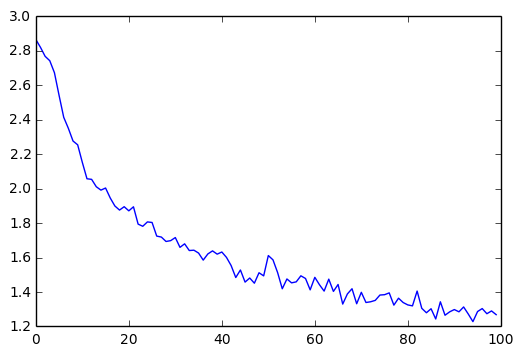

In [20]:
plt.figure()
plt.plot(all_losses)

/System/Library/Frameworks/Python.framework/Versions/2.7/Extras/lib/python/matplotlib/collections.py:548: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == 'face':


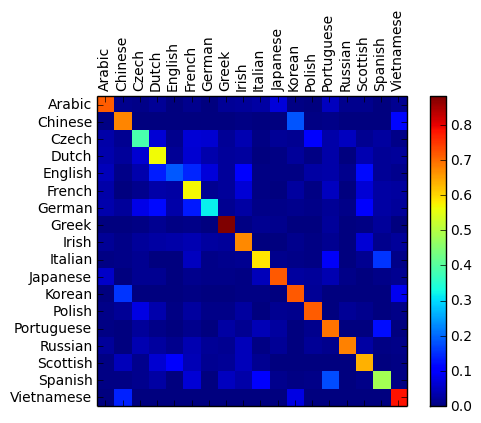

In [21]:
# Keep track of correct guesses in a confusion matrix
confusion = torch.zeros(n_categories, n_categories)
n_confusion = 10000

# Just return an output given a line
def evaluate(line_tensor):
    hidden = rnn.init_hidden()
    
    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)
    
    return output

# Go through a bunch of examples and record which are correctly guessed
for i in range(n_confusion):
    category, line, category_tensor, line_tensor = random_training_pair()
    output = evaluate(line_tensor)
    guess, guess_i = category_from_output(output)
    category_i = all_categories.index(category)
    confusion[category_i][guess_i] += 1

# Normalize by dividing every row by its sum
for i in range(n_categories):
    confusion[i] = confusion[i] / confusion[i].sum()

# Set up plot
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(confusion.numpy())
fig.colorbar(cax)

# Set up axes
ax.set_xticklabels([''] + all_categories, rotation=90)
ax.set_yticklabels([''] + all_categories)

# Force label at every tick
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

plt.show()